In [1]:
import matplotlib.pyplot as plt
# from data_analysis import *
import pandas as pd
import numpy as np
import os

# Dataset Units
UNIT_DICT = {"amazon-google": "H", "m5": "D", "glucose": "T", "meditation": "S", "patents": "M", "police": "D"} # See Pandas Frequency Units
UNIT_NUM_DICT = {"amazon-google": 1, "m5": 1, "glucose": 5, "meditation": 1, "patents": 1, "police": 1} # How many units per timestamp (ex: {6} hours)
SEASONALITY_DICT = {"amazon-google": 24, "m5": 7, "glucose": 1, "meditation": 1, "patents": 1, "police": 7} # Seasonality of data

In [7]:
# Select Dataset
dataset = 'amazon-google'

# File Naming
fn = f'../data/{dataset}/y_{dataset}.csv'
anomaly_dataset = f'{dataset}_anomaly'
anomaly_dir = f'../data/{anomaly_dataset}'
anomaly_fn = f'{anomaly_dir}/y_{anomaly_dataset}.csv'
anomaly_loc_fn = f'{anomaly_dir}/loc_{anomaly_dataset}.csv'

df = pd.read_csv(fn, index_col=0, parse_dates=['ds'])
display(df)
unique_ids = np.unique(df['unique_id'])
print(f'Unique IDs: {unique_ids}')

,ds,y,unique_id
0,2021-01-04 00:00:00,133,2
1,2021-01-04 01:00:00,118,2
2,2021-01-04 02:00:00,126,2
3,2021-01-04 03:00:00,124,2
4,2021-01-04 04:00:00,129,2
...,...,...,...
27355,2021-03-01 19:00:00,99,10
27356,2021-03-01 20:00:00,135,10
27357,2021-03-01 21:00:00,141,10
27358,2021-03-01 22:00:00,100,10


Unique IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [4]:
# select seasons to reduce/increase peak of the day
start_timestamp = pd.Timestamp("2021-02-01 00:00:00") # min(df['ds']) # or select manually
end_timestamp = max(df['ds'])
num_anomalies = 1 # num anomalies per timeseries
anomaly_len = 6 # num of timepoints per anomaly
strengths = [0.7, 1.5] # random selection for anomaly strength (multiplicative factor)

unit = UNIT_DICT[dataset]
unit_num = UNIT_NUM_DICT[dataset]
season_len = SEASONALITY_DICT[dataset] # Size of each season (ex: 24 times in a day)
if unit == 'M':
    freq_delta = pd.DateOffset(months=unit_num)
else:
    freq_delta = pd.Timedelta(unit_num, unit)
num_seasons = (end_timestamp - start_timestamp) // (season_len * freq_delta)

anomaly_df = df.copy()
anomalies = {} # Dict marking where each anomaly is in each time series

for id in unique_ids:
    # Select seasons to add anomalies to
    anomaly_seasons = [start_timestamp + season_len*season*freq_delta for season in np.random.choice(num_seasons, num_anomalies, replace=False)]
    anomaly_times = []
    for anomaly_season in anomaly_seasons:
        # Get time at the peak value of the season
        peak_index = df.loc[(df['unique_id']==id) & (df['ds'] >= anomaly_season) & (df['ds'] < (anomaly_season + freq_delta * season_len)), 'y'].idxmax()
        peak_time = df.loc[peak_index, 'ds']
        # Times to simulate anomalies (centered around peak)
        times = pd.date_range(peak_time-anomaly_len//2 * freq_delta, periods=anomaly_len, freq=unit)
        anomaly_times.extend(times)
        # select strength
        strength = np.random.choice(strengths)
        anomaly_filter = (anomaly_df['unique_id']==id) & (anomaly_df['ds'].isin(times))
        # Simulate Anomaly
        anomaly_df.loc[anomaly_filter, 'y'] *= strength
    anomalies[id] = anomaly_times

print(anomalies)


{0: [Timestamp('2021-02-03 20:00:00'), Timestamp('2021-02-03 21:00:00'), Timestamp('2021-02-03 22:00:00'), Timestamp('2021-02-03 23:00:00'), Timestamp('2021-02-04 00:00:00'), Timestamp('2021-02-04 01:00:00')], 1: [Timestamp('2021-02-21 11:00:00'), Timestamp('2021-02-21 12:00:00'), Timestamp('2021-02-21 13:00:00'), Timestamp('2021-02-21 14:00:00'), Timestamp('2021-02-21 15:00:00'), Timestamp('2021-02-21 16:00:00')], 2: [Timestamp('2021-02-28 17:00:00'), Timestamp('2021-02-28 18:00:00'), Timestamp('2021-02-28 19:00:00'), Timestamp('2021-02-28 20:00:00'), Timestamp('2021-02-28 21:00:00'), Timestamp('2021-02-28 22:00:00')], 3: [Timestamp('2021-02-20 16:00:00'), Timestamp('2021-02-20 17:00:00'), Timestamp('2021-02-20 18:00:00'), Timestamp('2021-02-20 19:00:00'), Timestamp('2021-02-20 20:00:00'), Timestamp('2021-02-20 21:00:00')], 4: [Timestamp('2021-02-07 16:00:00'), Timestamp('2021-02-07 17:00:00'), Timestamp('2021-02-07 18:00:00'), Timestamp('2021-02-07 19:00:00'), Timestamp('2021-02-07 2

/tmp/ipykernel_361711/1471705936.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31.5 57.  37.5 67.5 45.  55.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  anomaly_df.loc[anomaly_filter, 'y'] *= strength


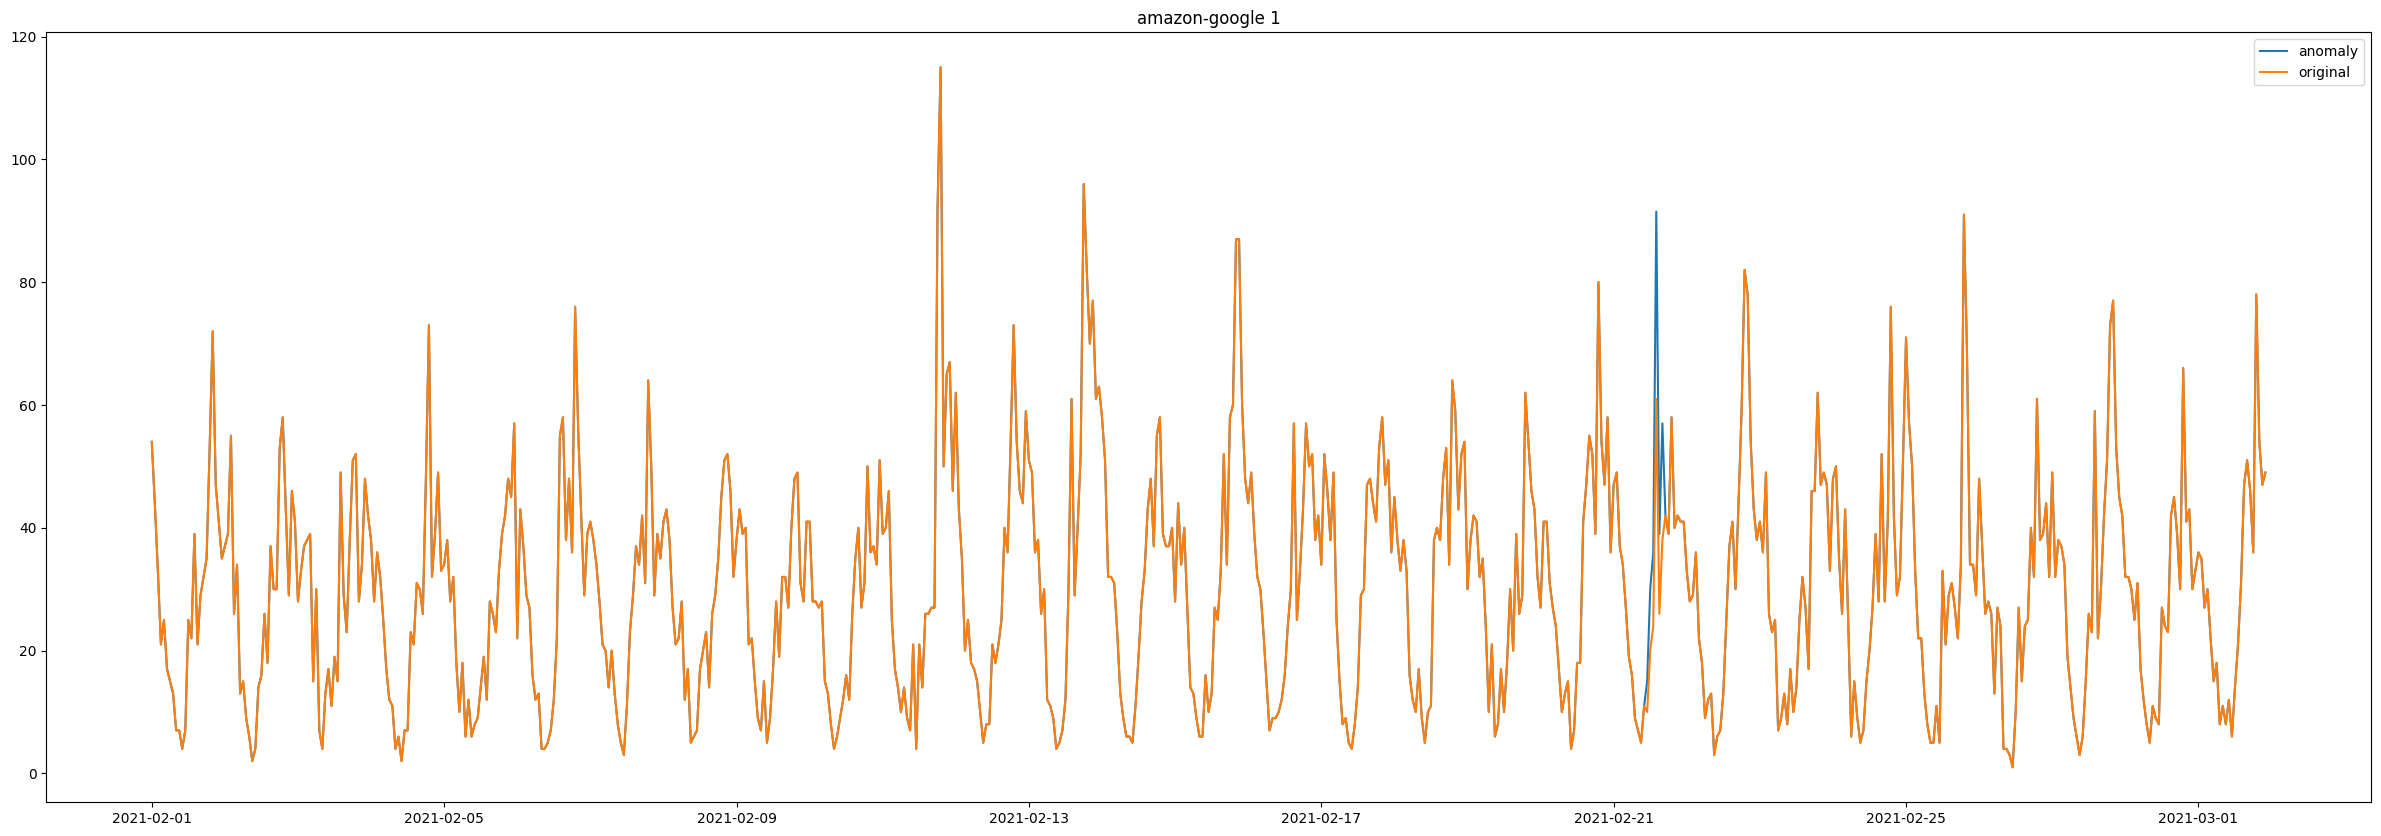

In [5]:
id = 1

x = df.loc[(df['unique_id'] == id) & (df['ds'] >= start_timestamp) & (df['ds'] < (end_timestamp)), 'ds']
y = df.loc[(df['unique_id'] == id) & (df['ds'].isin(x)), 'y']
y_anomaly = anomaly_df.loc[(anomaly_df['unique_id'] == id) & (anomaly_df['ds'].isin(x)), 'y']
plt.figure(figsize=(30,10))
plt.plot(x, y_anomaly, label='anomaly')
plt.plot(x, y, label='original')
plt.title(f"{dataset} {id}")
plt.legend()
plt.show()

In [6]:
# save anomalies
os.makedirs(anomaly_dir, exist_ok=True)
anomaly_df.to_csv(anomaly_fn, index=True)
anomaly_loc_df = pd.DataFrame.from_dict(anomalies)
anomaly_loc_df.to_csv(anomaly_loc_fn, index=True)